In [3]:
import pandas as pd
import tqdm     # 반복문 진행률

import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFGPT2LMHeadModel
import torch

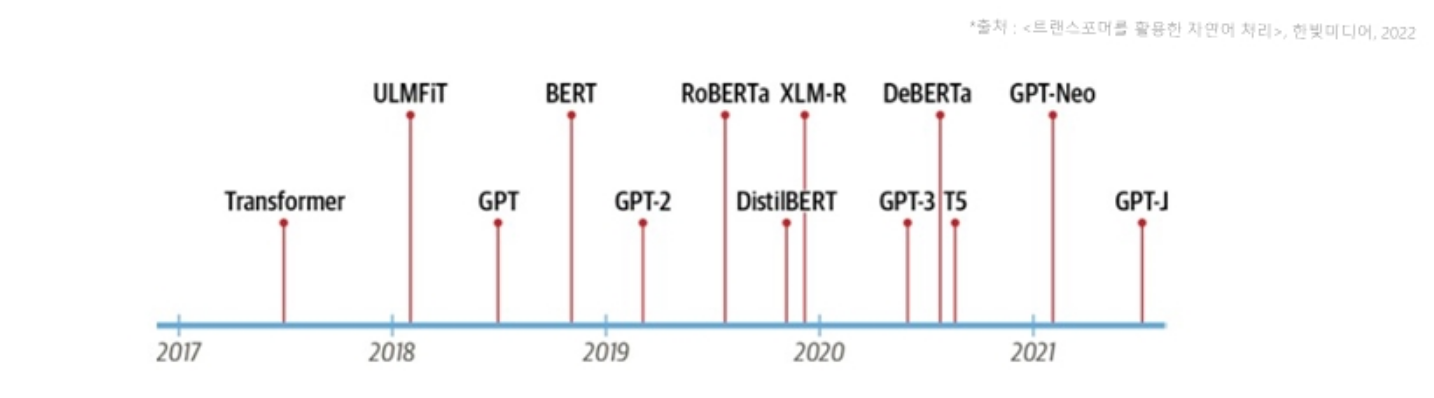
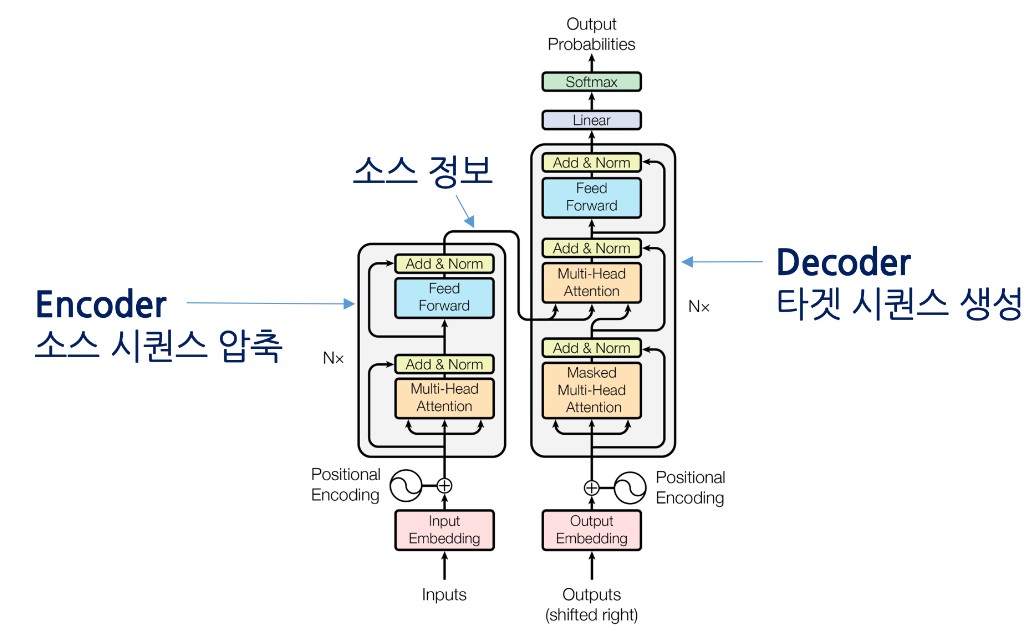
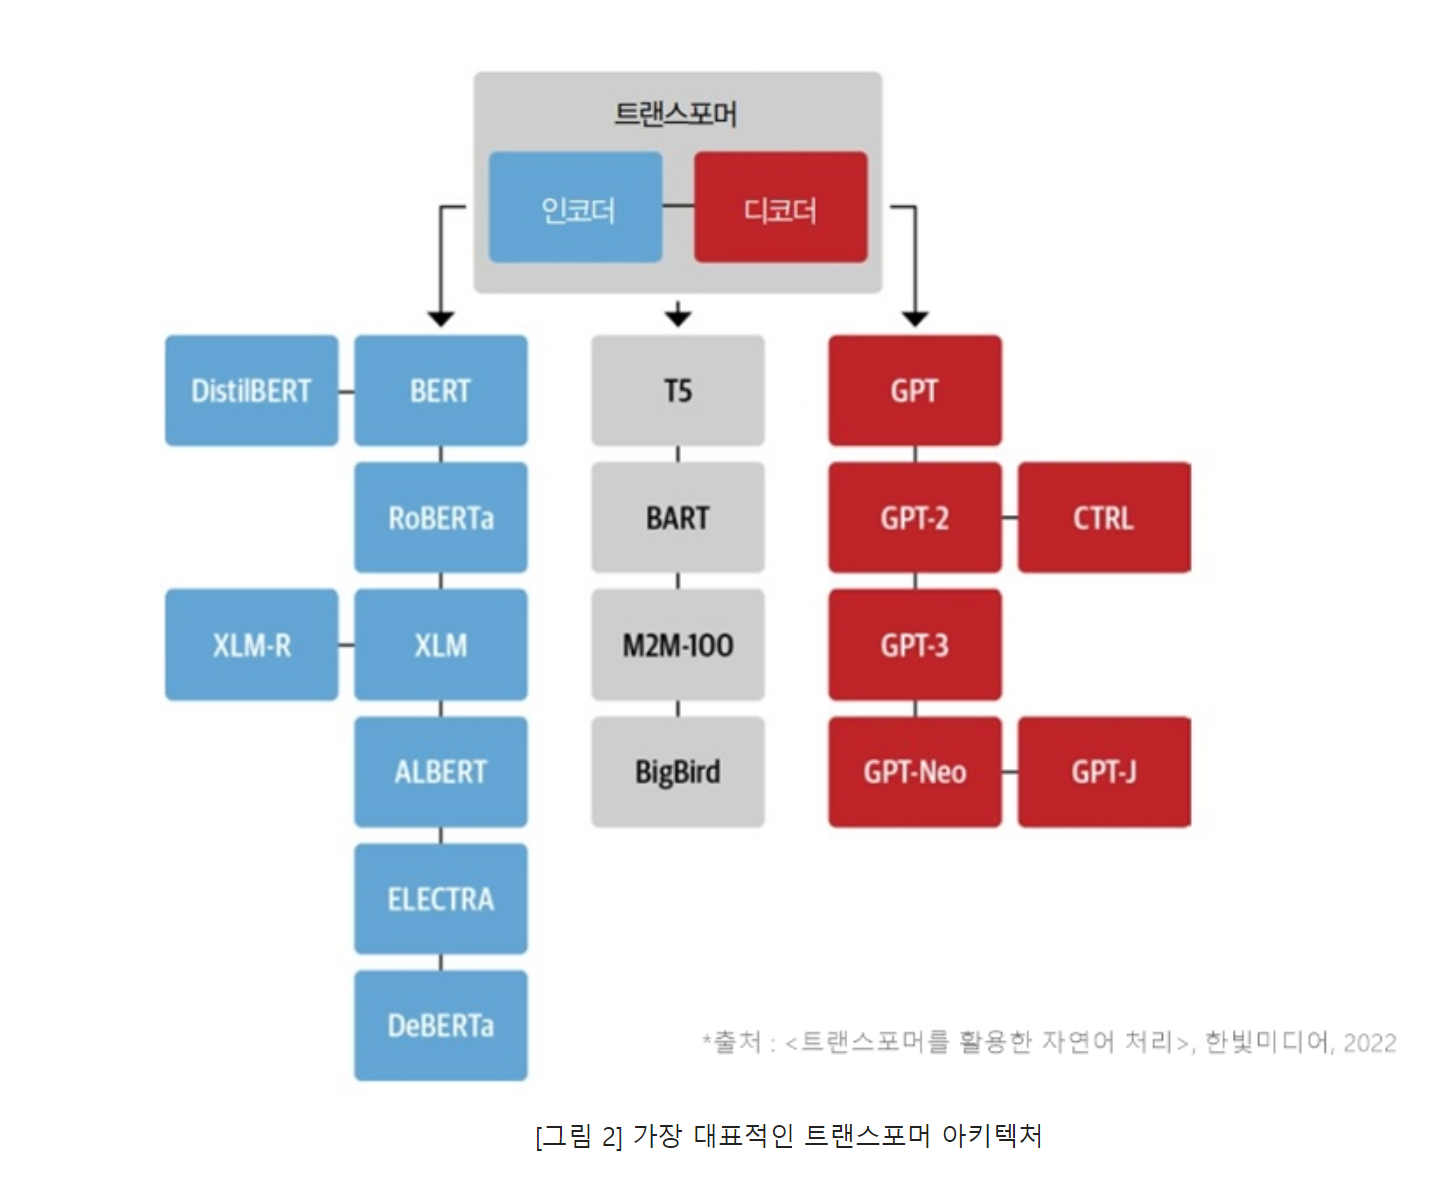

In [4]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
model = TFGPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.7.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'lm_head.weight', 'transformer.h.5.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.6.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

In [ ]:
tokenizer.eos_token_id

In [ ]:
df = pd.read_csv('train.csv')
df.head()

In [ ]:
print(tokenizer.bos_token_id)
print(tokenizer.eos_token_id)
print(tokenizer.pad_token_id)
print('-' * 10)
print(tokenizer.decode(1))
print(tokenizer.decode(2))
print(tokenizer.decode(3))
print(tokenizer.decode(4))

In [ ]:
batch_size = 32

In [ ]:
def get_chat_data():
    for question, answer in zip(df.Q.to_list(), df.A.to_list()):
        # start of sentence
        bos_token = [tokenizer.bos_token_id]

        # end of sentence
        eos_token = [tokenizer.eos_token_id]

        sent = tokenizer.encode('' + question + '' + answer)

        # 결과값을 나누어 얻음
        yield bos_token + sent + eos_token

In [ ]:
dataset = tf.data.Dataset.from_generator(get_chat_data, output_types = tf.int32)

In [ ]:
dataset = dataset.padded_batch(batch_size = batch_size, padded_shapes=(None,),
padding_values=tokenizer.pad_token_id)

In [ ]:
for i, batch in enumerate(dataset):
    print(i)
    print(batch)
    print('-----------------------------------------')

In [ ]:
for batch in dataset:
    print(batch)
    print(tokenizer.decode(batch[0]))
    break

In [ ]:
length = []
for batch in dataset:
    length.append(batch.shape[1])

In [ ]:
max(length)

In [ ]:
print(tokenizer.encode('네 예약하려면 어떻게 해야 하나요'))

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)

In [ ]:
steps = len(df) // batch_size + 1
print(steps)

In [ ]:
batch.shape

In [2]:
EPOCHS = 3

for epoch in range(EPOCHS):
    epoch_loss = 0

    for batch in tqdm.notebook.tqdm(dataset, total=steps):
        # tf.GradientTape() : 실행된 모든 연산은 테이프에 기록
        with tf.GradientTape() as tape:
            result = model(batch, labels=batch)
            loss = result[0]
            batch_loss = tf.reduce_mean(loss)
        
        grads = tape.gradient(batch_loss, model.trainable_variables)
        adam.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss += batch_loss / steps
    model.save_pretrained('model.h5')
    print('[Epoch: {:>4}] cost = {:>9}'.format(epoch + 1, epoch_loss))

NameError: name 'tqdm' is not defined

In [44]:
import transformers
transformers.__version__

'4.24.0'

In [43]:
from transformers import TFTrainer, TFTrainingArguments
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
)

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset,    # tensorflow_datasets training dataset
)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\trainer_tf.py:115: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(


In [45]:
trainer.train()

ValueError: The training dataset must have an asserted cardinality

In [1]:
model.save_pretrained('model.h5')

NameError: name 'model' is not defined

In [38]:
def return_answer_by_chatbot(user_text):
    sent = '' + user_text + ''
    input_ids = [tokenizer.bos_token_id] + tokenizer.encode(sent)
    input_ids = tf.convert_to_tensor([input_ids])
    output = model.generate(input_ids, max_length=96, do_sample=True, top_k=20)
    sentence = tokenizer.decode(output[0].numpy().tolist())
    chatbot_response = sentence.split('\n')[1]
    return chatbot_response
     

In [40]:
return_answer_by_chatbot('커피 한 잔 할까')

'커피'